<a href="https://colab.research.google.com/github/KaranjaspreetSingh/-React-TODO-APP/blob/main/movie_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie Recommendation System

Movie Recommendation Sytem using item-based collaborative filtering on the 25 million movielens dataset.

# **Importing Libraries required**

In [3]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
np.random.seed(123)
import seaborn as sns

!pip install pytorch-lightning
import pytorch_lightning as pl

In [4]:
# Adding movies dataset
movies = pd.read_csv('movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
#Adding ratings dataset
ratings = pd.read_csv('ratings.csv',
                      parse_dates=['timestamp'])
ratings.head()

<ipython-input-5-aac444634b19>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ratings = pd.read_csv('ratings.csv',


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
tags = pd.read_csv('tags.csv',
                      parse_dates=['timestamp'])
tags.head()

<ipython-input-6-a20fb5f6ad14>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tags = pd.read_csv('tags.csv',


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [7]:
tags.size

14732

# **Data Visualization**

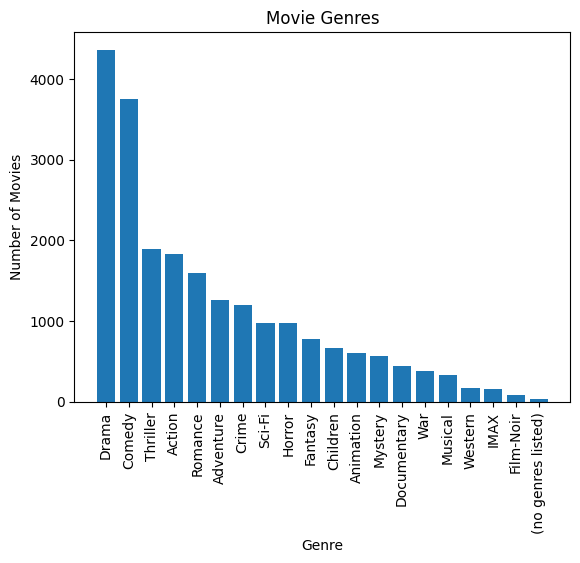

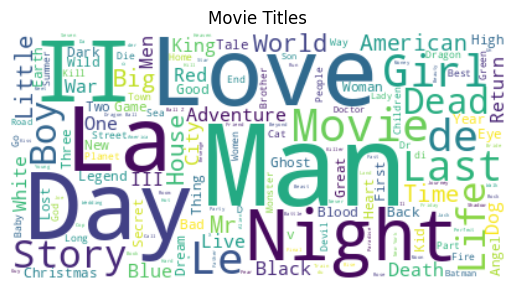

In [8]:
import matplotlib.pyplot as plt

# create a bar graph of movie genres
genres = movies['genres'].str.split('|', expand=True).stack().value_counts()
plt.bar(genres.index, genres.values)
plt.xticks(rotation=90)
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Movie Genres')
plt.show()

# create a word cloud of movie titles
from wordcloud import WordCloud

# join all movie titles into a single string
titles = ' '.join(movies['title'].tolist())

# generate word cloud
wordcloud = WordCloud(background_color='white').generate(titles)

# display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Movie Titles')
plt.show()

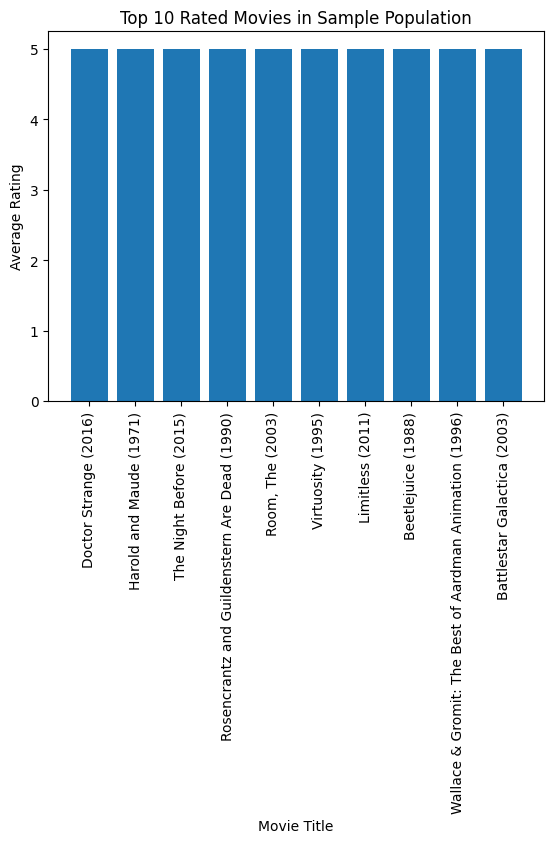

In [9]:
# merge ratings and movies dataset
merged_data = pd.merge(ratings, movies, on='movieId')

# get a random sample of the merged dataset
sample = merged_data.sample(n=1000)

# create a bar graph of the top 10 rated movies in the sample
top_10_rated_movies = sample.groupby(['title'])['rating'].mean().sort_values(ascending=False).head(10)
plt.bar(top_10_rated_movies.index, top_10_rated_movies.values)
plt.xticks(rotation=90)
plt.xlabel('Movie Title')
plt.ylabel('Average Rating')
plt.title('Top 10 Rated Movies in Sample Population')
plt.show()


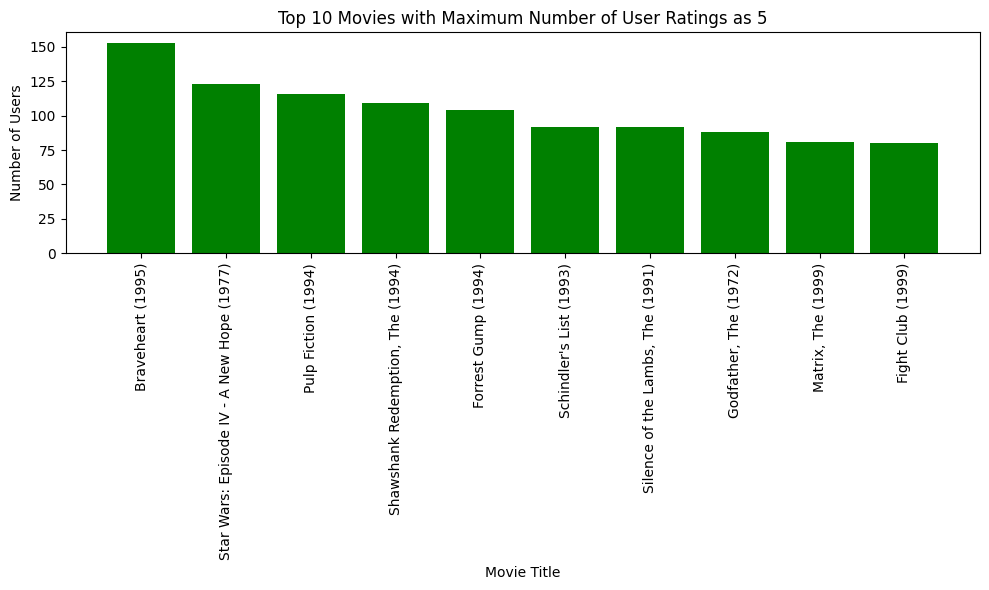

In [11]:
# Merge the movies and ratings dataframes using the movieid as the common column
merged_df = pd.merge(movies, ratings, on='movieId')

# Filter the merged dataframe to only include movies with a rating of 5
filtered_df = merged_df[merged_df['rating'] == 5]

# Group the filtered dataframe by the movieid and count the number of unique userids for each movie
grouped_df = filtered_df.groupby('movieId')['userId'].nunique()

# Get the top 10 movies with the highest number of users
top_10_movies = grouped_df.nlargest(10)

# Get the titles and number of users for the top 10 movies
result = movies[movies['movieId'].isin(top_10_movies.index)][['title', 'genres']]
result['num_users'] = top_10_movies.values

# Sort the result dataframe by the number of users in descending order
result = result.sort_values('num_users', ascending=False)

# Plot the graph
plt.figure(figsize=(10, 6))
plt.bar(result['title'], result['num_users'], color='green')
plt.xticks(rotation=90)
plt.xlabel('Movie Title')
plt.ylabel('Number of Users')
plt.title('Top 10 Movies with Maximum Number of User Ratings as 5')
plt.tight_layout()
plt.show()


In [12]:
merged_data = pd.merge(ratings, movies, on='movieId')

# filter movies with rating 5
rating_5_movies = merged_data[merged_data['rating'] == 5]

# count number of movies with rating 5
count = rating_5_movies.shape[0]

print("Number of movies with rating 5: ", count)

Number of movies with rating 5:  13211


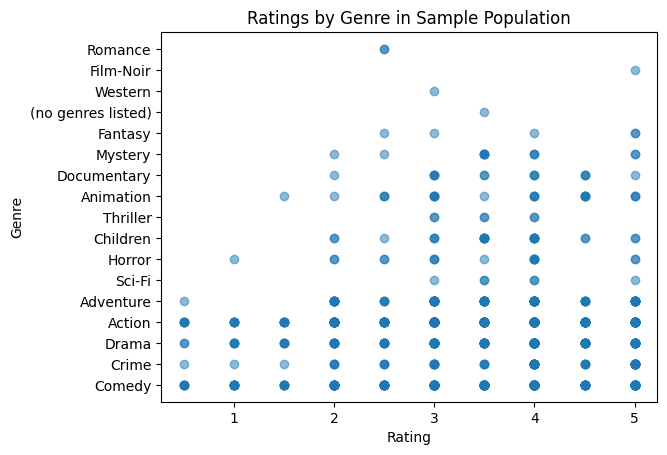

In [13]:
# create a scatter plot of ratings by genre
genres = movies['genres'].str.split('|', expand=True)
movies['primary_genre'] = genres[0]
sample_with_genre = pd.merge(sample, movies[['movieId', 'primary_genre']], on='movieId')

plt.scatter(sample_with_genre['rating'], sample_with_genre['primary_genre'], alpha=0.5)
plt.xlabel('Rating')
plt.ylabel('Genre')
plt.title('Ratings by Genre in Sample Population')
plt.show()


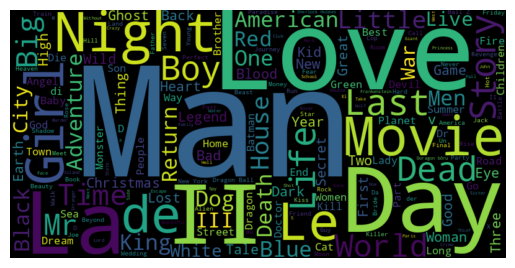

In [14]:
from wordcloud import WordCloud

# Concatenate all movie titles into a single string
all_titles = " ".join(movies["title"])

# Create a word cloud of the movie titles
wordcloud = WordCloud(width=800, height=400).generate(all_titles)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

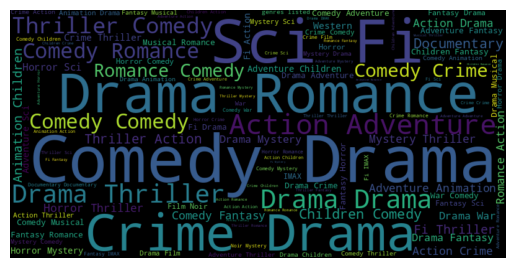

In [15]:
# Concatenate all movie titles into a single string
all_genres = " ".join(movies["genres"])

# Create a word cloud of the movie titles
wordcloud = WordCloud(width=800, height=400).generate(all_genres)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# **Train and Test Data**



In [16]:
ratings['timestamp'] = ratings['timestamp']
ratings['rank_latest'] = ratings.groupby(['userId'])['timestamp'] \
                                .rank(method='first', ascending=False)

# Splitting the data into training and testing data where rank either equal or not equal to 1
train_ratings = ratings[ratings['rank_latest'] != 1]
test_ratings = ratings[ratings['rank_latest'] == 1]

# drop columns that we no longer need which is timestamp since splitting is over
train_ratings = train_ratings[['userId', 'movieId', 'rating']]
test_ratings = test_ratings[['userId', 'movieId', 'rating']]

train_ratings.loc[:, 'rating'] = 1

train_ratings.sample(5)

,userId,movieId,rating
48199,312,4128,1.0
95240,600,914,1.0
2951,19,3705,1.0
59220,386,494,1.0
80132,503,5418,1.0


In [17]:
#Generating random nehative values (0) for each positive interaction (1) on the ratio of 4:1

# Get a list of all movie IDs
all_movieIds = ratings['movieId'].unique()

# Placeholders that will hold the training data
users, items, labels = [], [], []

# This is the set of items that each user has interaction with
user_item_set = set(zip(train_ratings['userId'], train_ratings['movieId']))

# 4:1 ratio of negative to positive samples
num_negatives = 4

for (u, i) in tqdm(user_item_set):
    users.append(u)
    items.append(i)
    labels.append(1) # items that the user has interacted with are positive
    for _ in range(num_negatives):
        # randomly select an item
        negative_item = np.random.choice(all_movieIds)
        # check that the user has not interacted with this item
        while (u, negative_item) in user_item_set:
            negative_item = np.random.choice(all_movieIds)
        users.append(u)
        items.append(negative_item)
        labels.append(0) # items not interacted with are negative

  0%|          | 0/100226 [00:00<?, ?it/s]

# Creating a class to generate tensors of user and item entires

In [18]:
class MovieLensTrainDataset(Dataset):
    """MovieLens PyTorch Dataset for Training

    Args:
        ratings (pd.DataFrame): Dataframe containing the movie ratings
        all_movieIds (list): List containing all movieIds

    """

    def __init__(self, ratings, all_movieIds):
        self.users, self.items, self.labels = self.get_dataset(ratings, all_movieIds)

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]

    def get_dataset(self, ratings, all_movieIds):
        users, items, labels = [], [], []
        user_item_set = set(zip(ratings['userId'], ratings['movieId']))

        num_negatives = 4
        for u, i in user_item_set:
            users.append(u)
            items.append(i)
            labels.append(1)
            for _ in range(num_negatives):
                negative_item = np.random.choice(all_movieIds)
                while (u, negative_item) in user_item_set:
                    negative_item = np.random.choice(all_movieIds)
                users.append(u)
                items.append(negative_item)
                labels.append(0)

        return torch.tensor(users),torch.tensor(items),torch.tensor(labels)

In [37]:
class MovieLensValDataset(Dataset):
    """MovieLens PyTorch Dataset for Validation

    Args:
        ratings (pd.DataFrame): Dataframe containing the validation movie ratings
        all_movieIds (list): List containing all movieIds
    """

    def __init__(self, ratings, all_movieIds, num_negatives=2):
        self.users, self.items, self.labels = self.get_dataset(ratings, all_movieIds, num_negatives)

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]

    def get_dataset(self, ratings, all_movieIds, num_negatives):
        users, items, labels = [], [], []
        user_item_set = set(zip(ratings['userId'], ratings['movieId']))

        for u, i in user_item_set:
            users.append(u)
            items.append(i)
            labels.append(1)  # Positive sample

            # Adding a few negative samples for validation
            for _ in range(num_negatives):
                negative_item = np.random.choice(all_movieIds)
                while (u, negative_item) in user_item_set:
                    negative_item = np.random.choice(all_movieIds)
                users.append(u)
                items.append(negative_item)
                labels.append(0)  # Negative sample

        return torch.tensor(users), torch.tensor(items), torch.tensor(labels)


class MovieLensTestDataset(Dataset):
    """MovieLens PyTorch Dataset for Testing

    Args:
        ratings (pd.DataFrame): Dataframe containing the test movie ratings
        all_movieIds (list): List containing all movieIds
    """

    def __init__(self, ratings, all_movieIds, num_negatives=99):
        self.users, self.items, self.labels = self.get_dataset(ratings, all_movieIds, num_negatives)

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]

    def get_dataset(self, ratings, all_movieIds, num_negatives):
        users, items, labels = [], [], []
        user_item_set = set(zip(ratings['userId'], ratings['movieId']))

        for u, i in user_item_set:
            users.append(u)
            items.append(i)
            labels.append(1)  # Positive sample

            # Adding more negative samples for testing
            for _ in range(num_negatives):
                negative_item = np.random.choice(all_movieIds)
                while (u, negative_item) in user_item_set:
                    negative_item = np.random.choice(all_movieIds)
                users.append(u)
                items.append(negative_item)
                labels.append(0)  # Negative sample

        return torch.tensor(users), torch.tensor(items), torch.tensor(labels)


# Creating a class to process the pytorch lightning model

In [44]:
from torchmetrics.classification import Accuracy

class NCF(pl.LightningModule):
    """ Neural Collaborative Filtering (NCF)

        Args:
            num_users (int): Number of unique users
            num_items (int): Number of unique items
            ratings (pd.DataFrame): Dataframe containing the movie ratings for training
            all_movieIds (list): List containing all movieIds (train + test)
    """

    def __init__(self, num_users, num_items, ratings, all_movieIds):
        super().__init__()
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=8)
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=8)
        self.fc1 = nn.Linear(in_features=16, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=1)
        self.ratings = ratings
        self.all_movieIds = all_movieIds

        self.train_accuracy = Accuracy(task="binary")
        self.val_accuracy = Accuracy(task="binary")
        self.test_accuracy = Accuracy(task="binary")


    def forward(self, user_input, item_input):

        # Pass through embedding layers
        user_embedded = self.user_embedding(user_input)
        item_embedded = self.item_embedding(item_input)

        # Concat the two embedding layers
        vector = torch.cat([user_embedded, item_embedded], dim=-1)

        # Pass through dense layer
        vector = nn.ReLU()(self.fc1(vector))
        vector = nn.ReLU()(self.fc2(vector))

        # Output layer
        pred = nn.Sigmoid()(self.output(vector))

        return pred.squeeze(-1)

    def training_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.BCELoss()(predicted_labels, labels.view(-1, 1).float())

        acc = self.train_accuracy(predicted_labels, labels)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, prog_bar=True)

        return loss


    def validation_step(self, batch, batch_idx):
        # Validation step
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.BCELoss()(predicted_labels, labels.view(-1, 1).float())

        # Log validation accuracy
        acc = self.val_accuracy(predicted_labels, labels)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        # Testing step, if needed
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.BCELoss()(predicted_labels, labels.view(-1, 1).float())

        # Log test accuracy
        acc = self.val_accuracy(predicted_labels, labels)
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test_acc", acc, on_step=False, on_epoch=True, prog_bar=True)


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def train_dataloader(self):
        return  DataLoader(MovieLensTrainDataset (self.ratings,self.all_movieIds), batch_size=512, num_workers=4)


In [48]:
from torchmetrics.classification import Accuracy

class NCF(pl.LightningModule):
    def __init__(self, num_users, num_items, ratings, all_movieIds):
        super().__init__()
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=8)
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=8)
        self.fc1 = nn.Linear(in_features=16, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=1)
        self.ratings = ratings
        self.all_movieIds = all_movieIds

        self.train_accuracy = Accuracy(task="binary")
        self.val_accuracy = Accuracy(task="binary")
        self.test_accuracy = Accuracy(task="binary")

    def forward(self, user_input, item_input):
        user_embedded = self.user_embedding(user_input)
        item_embedded = self.item_embedding(item_input)
        vector = torch.cat([user_embedded, item_embedded], dim=-1)
        vector = nn.ReLU()(self.fc1(vector))
        vector = nn.ReLU()(self.fc2(vector))
        pred = nn.Sigmoid()(self.output(vector))
        return pred.squeeze(-1)

    def training_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.BCELoss()(predicted_labels, labels.float())

        acc = self.train_accuracy(predicted_labels, labels.int())
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.BCELoss()(predicted_labels, labels.float())

        acc = self.val_accuracy(predicted_labels, labels.int())
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.BCELoss()(predicted_labels, labels.float())

        acc = self.test_accuracy(predicted_labels, labels.int())
        self.log("test_loss", loss, on_epoch=True, prog_bar=True)
        self.log("test_acc", acc, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def train_dataloader(self):
        return DataLoader(MovieLensTrainDataset(self.ratings, self.all_movieIds), batch_size=512, num_workers=4)

    def val_dataloader(self):
        return DataLoader(MovieLensValDataset(self.ratings, self.all_movieIds), batch_size=512, num_workers=4)

    def test_dataloader(self):
        return DataLoader(MovieLensTestDataset(self.ratings, self.all_movieIds), batch_size=512, num_workers=4)

In [49]:
# Correcting the conversion to integer
num_users = int(ratings['userId'].max() + 1)
num_items = int(ratings['movieId'].max() + 1)

# Getting unique movie IDs as an array
all_movieIds = ratings['movieId'].unique()

# Initialize the NCF model
model = NCF(num_users, num_items, all_movieIds,train_ratings)

In [50]:
train_dataset = MovieLensTrainDataset(ratings, all_movieIds)
val_dataset = MovieLensValDataset(ratings, all_movieIds, num_negatives=2)
test_dataset = MovieLensTestDataset(ratings, all_movieIds, num_negatives=99)


train_dataloader = DataLoader(train_dataset, batch_size=512, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=512, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=512, num_workers=4)

In [51]:
# Training our NCF model for 5 epochs using the GPU.
#model = model.to('cuda')
trainer = pl.Trainer(max_epochs= 10, logger=True)
#gpus=1, reload_dataloaders_every_epoch=True, progress_bar_refresh_rate=50,checkpoint_callback=False
trainer.fit(model, train_dataloader, val_dataloader)

trainer.test(model, test_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type           | Params | Mode 
----------------------------------------------------------
0 | user_embedding | Embedding      | 4.9 K  | train
1 | item_embedding | Embedding      | 1.5 M  | train
2 | fc1            | Linear         | 1.1 K  | train
3 | fc2            | Linear         | 2.1 K  | train
4 | output         | Linear         | 33     | train
5 | train_accuracy | BinaryAccuracy | 0      | train
6 | val_accuracy   | BinaryAccuracy | 0      | train
7 | test_accuracy  | BinaryAccuracy | 0      | train
----------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.228     Total estimated model para

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9364498853683472     │
│         test_loss         │    0.17742210626602173    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.17742210626602173, 'test_acc': 0.9364498853683472}]

In [52]:
# User-item pairs for testing
test_user_item_set = set(zip(test_ratings['userId'], test_ratings['movieId']))

# Dict of all items that are interacted with by each user
user_interacted_items = ratings.groupby('userId')['movieId'].apply(list).to_dict()

hits = []
for (u,i) in tqdm(test_user_item_set):
    interacted_items = user_interacted_items[u]
    not_interacted_items = set(all_movieIds) - set(interacted_items)
    selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
    test_items = selected_not_interacted + [i]

    predicted_labels = np.squeeze(model(torch.tensor([u]*100),
                                        torch.tensor(test_items)).detach().numpy())

    top10_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]

    if i in top10_items:
        hits.append(1)
    else:
        hits.append(0)

print("The Hit Ratio @ 10 is {:.2f}".format(np.average(hits)))

  0%|          | 0/610 [00:00<?, ?it/s]

The Hit Ratio @ 10 is 0.62


In [53]:
print(hits), len(hits)

[0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 

(None, 610)

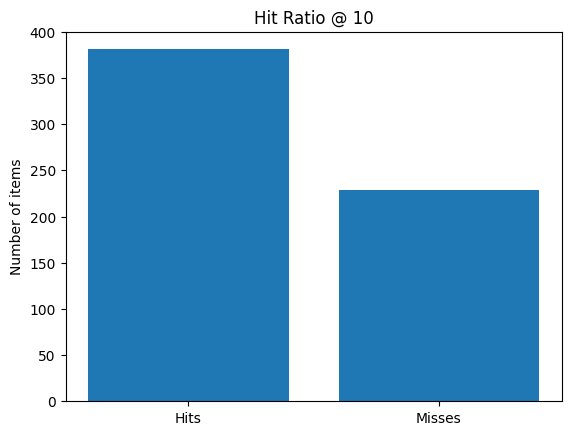

In [54]:
#graphically understanding the number of hits
import matplotlib.pyplot as plt

# Count the number of hits and misses
num_hits = sum(hits)
num_misses = len(hits) - num_hits

# Create a bar chart
plt.bar(['Hits', 'Misses'], [num_hits, num_misses])
plt.title('Hit Ratio @ 10')
plt.ylabel('Number of items')
plt.show()


In [55]:
print(top10_items)

[2628, 3793, 339, 910, 466, 57669, 6787, 1029, 413, 1285]


In [57]:
# Create a dictionary of movie IDs and titles
id2title = {movie_id: movie_title for movie_id, movie_title in zip(movies["movieId"], movies["title"])}

# Iterate through the top 10 items in each hit and print their titles
for (u, i) in tqdm(test_user_item_set):
    interacted_items = user_interacted_items[u]
    not_interacted_items = set(all_movieIds) - set(interacted_items)
    selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
    test_items = selected_not_interacted + [i]

    predicted_labels = np.squeeze(model(torch.tensor([u]*100),
                                        torch.tensor(test_items)).detach().numpy())

    top10_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]

    if i in top10_items:
        hits.append(1)
        top10_titles = [id2title[item] for item in top10_items]
        print(f"\nUser {u}, recommended movie '{id2title[i]}' was a hit!")
        print("Top 10 recommended movies:")
        for title in top10_titles:
            print(title)
    else:
        hits.append(0)

  0%|          | 0/610 [00:00<?, ?it/s]


User 69, recommended movie 'Cast Away (2000)' was a hit!
Top 10 recommended movies:
Cast Away (2000)
Full Metal Jacket (1987)
Blues Brothers, The (1980)
Judge Dredd (1995)
Kingpin (1996)
Addams Family, The (1991)
Kick-Ass (2010)
Anchorman: The Legend of Ron Burgundy (2004)
From Russia with Love (1963)
The Martian (2015)

User 283, recommended movie 'Home Alone (1990)' was a hit!
Top 10 recommended movies:
Home Alone (1990)
Edward Scissorhands (1990)
Beauty and the Beast (1991)
Goodfellas (1990)
Heat (1995)
Heat (1995)
Ratatouille (2007)
Road Trip (2000)
Zombieland (2009)
Manchurian Candidate, The (1962)

User 396, recommended movie 'Toy Story 2 (1999)' was a hit!
Top 10 recommended movies:
Sleepless in Seattle (1993)
Toy Story 2 (1999)
Rocky Horror Picture Show, The (1975)
50 First Dates (2004)
Spaceballs (1987)
Talented Mr. Ripley, The (1999)
12 Angry Men (1957)
Escape from New York (1981)
Intolerable Cruelty (2003)
Dawn of the Dead (1978)

User 36, recommended movie 'Shawshank Redem

In [62]:
import torch
from torch.utils.data import DataLoader, Dataset

def retrain_model(model, user_feedback, user_id, ratings, all_movieIds, epochs=5, batch_size=512):
    """
    Retrain the NCF model based on user feedback.

    Args:
        model (NCF): The Neural Collaborative Filtering model.
        user_feedback (list): List of feedback entries ('yes' or 'no') from the user.
        user_id (int): The ID of the user providing feedback.
        ratings (pd.DataFrame): Dataframe containing the movie ratings.
        all_movieIds (list): List containing all movieIds.
        epochs (int): Number of epochs to train the model.
        batch_size (int): Size of each training batch.
    """

    # Convert user feedback to labels
    user_item_feedback = []
    for feedback in user_feedback:
        # Extract the user-item pair and convert 'yes'/'no' to binary labels
        item_id = feedback['item_id']  # The ID of the item rated
        label = 1 if feedback['label'] == 'yes' else 0
        user_item_feedback.append((user_id, item_id, label))

    # Create a new ratings DataFrame or append to existing ratings
    new_ratings = pd.DataFrame(user_item_feedback, columns=['userId', 'movieId', 'label'])

    # Combine new feedback with the existing ratings
    combined_ratings = pd.concat([ratings, new_ratings], ignore_index=True)

    # Create a new DataLoader for the retraining dataset
    train_dataset = MovieLensTrainDataset(combined_ratings, all_movieIds)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Retrain the model
    model.train()
    for epoch in range(epochs):
        for batch in train_loader:
            user_input, item_input, labels = batch
            optimizer.zero_grad()
            predicted_labels = model(user_input, item_input)
            loss = nn.BCELoss()(predicted_labels, labels.view(-1, 1).float())
            loss.backward()
            optimizer.step()

    # Save the retrained model
    torch.save(model.state_dict(), 'retrained_ncf_model.pth')
    print(f"Model retrained and saved as 'retrained_ncf_model.pth'.")

# Example usage (within your feedback collection logic):
# Assuming 'model' is your trained NCF model, 'user_feedback' is a list of feedback dictionaries.
# user_feedback = [{'item_id': 1, 'label': 'yes'}, {'item_id': 2, 'label': 'no'}, ...]
# retrain_model(model, user_feedback, specific_user, ratings, all_movieIds)


In [64]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle  # For saving the model

# Create a dictionary of movie IDs and titles
id2title = {movie_id: movie_title for movie_id, movie_title in zip(movies["movieId"], movies["title"])}

# Ask for the specific user number
specific_user = int(input("Enter your user number: "))  # Input user number

# Placeholder for user feedback
user_feedback = []

# Define a threshold for how many feedback entries are required before retraining
MIN_FEEDBACK_THRESHOLD = 1  # You can adjust this threshold

# Iterate through the test_user_item_set but only for the specific user
for (u, i) in tqdm(test_user_item_set):
    if u != specific_user:
        continue  # Skip other users

    interacted_items = user_interacted_items[u]
    not_interacted_items = set(all_movieIds) - set(interacted_items)
    selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
    test_items = selected_not_interacted + [i]

    predicted_labels = np.squeeze(model(torch.tensor([u]*100),
                                        torch.tensor(test_items)).detach().numpy())

    top10_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]

    # Collect feedback only if the user has interacted with the recommended movie
    if i in top10_items:
        hits.append(1)
        top10_titles = [id2title[item] for item in top10_items]
        print(f"\nUser {u}, recommended movie '{id2title[i]}' was a hit!")
        print("Top 10 recommended movies:")
        for title in top10_titles:
            print(title)

        # Collect feedback from the specific user
        while True:
            feedback = input("Did you like the recommended movie? (yes/no): ").strip().lower()
            if feedback in ['yes', 'no']:
                user_feedback.append((u, i, 1 if feedback == 'yes' else 0))  # Store feedback
                break
            else:
                print("Invalid input. Please enter 'yes' or 'no'.")

# After collecting enough feedback, retrain the model
if len(user_feedback) >= MIN_FEEDBACK_THRESHOLD:
    # Create a DataFrame or other structure to update your dataset
    feedback_df = pd.DataFrame(user_feedback, columns=['userId', 'movieId', 'feedback'])

    # Combine this feedback with your original dataset for retraining
    updated_ratings = pd.concat([ratings, feedback_df], ignore_index=True)

    # Retrain your model using the updated ratings
    # Assuming you have a retrain_model function defined:
    model = retrain_model(updated_ratings)

    # Save the retrained model
    with open('retrained_model.pth', 'wb') as f:
        torch.save(model.state_dict(), f)
    print("Model retrained and saved successfully.")
else:
    print("Not enough feedback collected to retrain the model.")


Enter your user number: 234



100%|██████████| 610/610 [00:00<00:00, 113465.14it/s]

Not enough feedback collected to retrain the model.
